In [1]:
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import pandas as pd
import math
import csv
import heapq
import random

In [2]:
def find_attributes(d):
    with open(d.filename, 'r', newline='') as file:
        reader = csv.reader(file)
        return (next(reader))

In [3]:
def get_raw_data(d):
    unsorted_values = []   
    with open(d.filename, 'r', newline='') as file:
        reader = csv.reader(file)
        next(reader)#skip labels
        for row in reader:
            unsorted_values.append(row)
            
    return unsorted_values

In [4]:
def attribute_values(d):
    vals = np.transpose(d.raw)
    new_vals = []
        
    for i in range(len(vals)):
        inner = []
        for j, val in enumerate(vals[i]):
            
            try:
                inner.append(float(val))
            except:
                inner.append(val)
        new_vals.append(inner)
    return new_vals
    

In [5]:
# sorts a 2d array by some column, using merge sort (smallest to largest)
def merge_sort_2d(array, index):######ONLY USE FOR INTEGERS OR DOUBLES########NO STRINGS########

    if len(array) == 1:
        return array
    
    
    split_location = len(array)//2
    
    half1 = merge_sort_2d(array[:split_location], index)
    half2 = merge_sort_2d(array[split_location:], index)
    
    merged_list = []
    
    counter1 = 0
    counter2 = 0
    
    for i in range(len(array)):
        if(counter1 < len(half1) and counter2 < len(half2)):
            if(half1[counter1][index] < half2[counter2][index]):
                merged_list.append(half1[counter1])
                counter1+=1
            else:
                merged_list.append(half2[counter2])
                counter2+=1
        else:
            break
            
    while(counter1 < len(half1)):#one of these will not be true
        merged_list.append(half1[counter1])
        counter1+=1
    while(counter2 < len(half2)):
        merged_list.append(half2[counter2])
        counter2+=1
        
        
    return merged_list

In [6]:
def normalize_list(data):
    min_val = min(data)
    max_val = max(data)
    
    return [(x - min_val) / (max_val - min_val) for x in data]

In [7]:
def identify_classifications(data): #classifications will be the final column of the dataset
    
    classifications = []
    
    classifications.append(data[0])
    for i in range(len(data)):
        #make a list with each unique class found
        match = False
        for c in classifications:
            if(data[i] == c):
                match = True
                break
        
        if(not match):
            classifications.append(data[i])
                
    return classifications

In [8]:
class Dataset():
    def __init__(self, filename):
        self.filename = f"{filename}.csv"
        self.raw = get_raw_data(self)
        self.attributes = find_attributes(self)
        self.number_of_attributes = len(self.attributes)
        self.attribute_values = attribute_values(self)
        self.classifications =  identify_classifications(self.attribute_values[self.number_of_attributes - 1])#classes will be assumed to be the final coulumn in raw data
        
    
    
    def get_attributes():
        return self.attributes
    
    def sort_by_raw(self,index):#return a dataset object sorted by some specific attribute
        return merge_sort_2d(self.raw,index)
        
    def update_attribute_values(self, new_d):#ex: after sorted by some index
        self.attribute_values = new_d
        
    def restore_raw(self):#once the attributes have been updated, restore raw data so that it can happen again 
        self.raw = get_raw_data(self)
    
    def pre_normalize_raw(self):#normalize the data and update the raw data
        temp = attribute_values(self)#get values transposed and converted to a floats
        temp_2 = []
        for i, vals in enumerate(temp):
            try:
                temp_2.append(normalize_list(vals))#normalize
            except TypeError:
                temp_2.append(vals)#except strings
        self.raw = np.transpose(temp_2)#update raw data so that the yoink works more cleanly
    
    def yoink_data_point(self): #grab a random point and reset the dataset to not include it
        p = random.randint(0,149)
        non_normalized = self.raw[p]
        self.pre_normalize_raw()
        point = self.raw[p]
        
        self.raw = np.delete(self.raw, p, axis=0)#change raw data
        self.attribute_values = attribute_values(self)#recreate attribute values excluding point yoinked
        self.restore_raw()
        
        converted_point = []
        
        for p in point:
            try:
                converted_point.append(float(p))
            except ValueError:
                converted_point.append(p)
        return converted_point, non_normalized
    
    def post_yoink_restore(self):
        self.attribute_values = attribute_values(self)
        

In [9]:
class ScatterPlot:
    def __init__(self, x_vals, y_vals, dataset, figsize=(8, 6), title="KNN model visual", xlabel="X", ylabel="Y", grid=True):
        self.x_vals = [float(x) for x in x_vals]
        self.y_vals = [float(y) for y in y_vals]
        self.dataset = dataset
        self.size = figsize
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.grid = grid
        
    def display(self, point_to_add = None):
        # Create the plot
        plt.figure(figsize = (14, 6))
        #split the data into each unique category
        classifications = self.dataset.classifications
        x_list = [[] for i in classifications]
        y_list = [[] for i in classifications]
        
        
        point_classifications = self.dataset.attribute_values[-1]
        
        pair_counter = 0#outside loop counter(keep track of what pair is being compared)
        
        
        for p in point_classifications:
            counter = 0#inside loop counter (compare classifications)
            for c in classifications:
                if p == c:
                    x_list[counter].append(self.x_vals[pair_counter])
                    y_list[counter].append(self.y_vals[pair_counter])
                    break
                else:
                    counter += 1
                    
            pair_counter += 1
                        
        
                
        for i in range(len(classifications)):
            match i:
                case 0:
                    color_picker = 'blue'
                case 1:
                    color_picker = 'red'
                case 2:
                    color_picker = 'green'
                case 3:
                    color_picker = 'black'
                case 4:
                    color_picker = 'orange'
            
            plt.scatter(x_list[i],y_list[i],color = color_picker,label=f'{classifications[i]}')
        
        
        ##add the point that was taken out of the set##
        if(point_to_add is not None):
            plt.scatter(float(point_to_add[0]),float(point_to_add[1]), color = 'pink', label='Query point',edgecolor ='black', s = 100)
        
        
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.legend(title="Classifications", 
                  loc='best',  
                  fontsize='small',
                  title_fontsize='medium')
        plt.grid(self.grid)
        plt.show()
        
    
        

In [10]:
def euclidian_distance(d, p):
    
    distances = [0] * len(d.attribute_values[0])#list to store each distance
    p_location = 0 
    for att in d.attribute_values:
        counter = 0
        for val in att:
            try:  
                distances[counter] += (val - p[p_location])** 2
                counter+=1
            except TypeError:#no strings
                pass
        p_location += 1
        
        
        
    for i, dist in enumerate (distances):
        distances[i] = math.sqrt(dist)
    return distances

In [11]:
class KNN_Object():
    def __init__ (self, d):
        self.d = d#the dataset object
        self.graph = ScatterPlot(d.attribute_values[0],
                                 d.attribute_values[1], 
                                 self.d,
                                 "KNN model(2d)", 
                                 xlabel = d.attributes[0], 
                                 ylabel = d.attributes[1])
                   #the graph will only display the first two attributes in the list
                   #can also serve as an example of how high dimensional data doesn't calssify well using this algorithm
    def display(self, point_to_add = None):
        self.graph.display(point_to_add )
        
    
    def categorize(self, p, display):#takes some point p and decides its category based on the KNN algorithm
        neighbor_distances = euclidian_distance(self.d, p)
        closest_7 = heapq.nsmallest(7,enumerate(neighbor_distances), key=lambda x: x[1])
        
        indicies = [idx for idx, dist in closest_7]
        
        
        if(display):
            print(f"The datapoint randomly pulled from the set had {self.d.attributes[self.d.number_of_attributes - 1]}: {p[len(p) - 1]}")
            print(f"The closest neighbors identified have indicies {indicies}")
        
        #use the generic classification list to find classification
        
        classifications = self.d.classifications
        
        points = [0] * len(classifications)

        for i in range(7):
            for j in range(len(classifications)):
                if(self.d.attribute_values[self.d.number_of_attributes - 1][indicies[i]] == classifications[j]):#which class are the indicies in
                    #add one point to point[j] (give the classification a point)
                    points[j] += 1
                    break#don't need to compare further
                
        winner = 0    
        for k in range(len(points)):
            if(points[k] > winner):
                winner = k
                
        if(display):
            print(f"The model has classified the point as {self.d.attributes[self.d.number_of_attributes - 1]}: {classifications[winner]}")
        
        return classifications[winner]
    
    

Incorrect outcome: model predicted Virginica, correct value is Versicolor


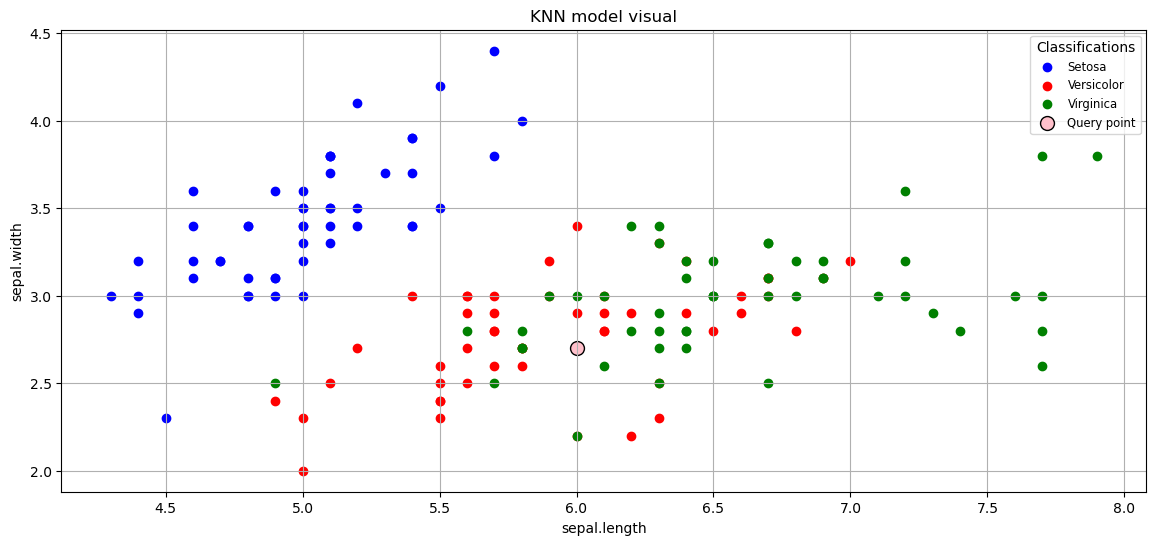


Ratio of correct model outcomes: 90.0%
Ratio of correct model outcomes: 100.0%


In [22]:
iris_dataset = Dataset("iris")#this returns an object with attributes and their values 

iris_model = KNN_Object(iris_dataset)
#model.display()


correct = 0
incorrect = 0
for i in range(10):
    p,n = iris_dataset.yoink_data_point()
    result = iris_model.categorize(p, False)
    iris_dataset.post_yoink_restore()
    
    if(p[-1] == result):
        correct += 1
    else:
        print(f"Incorrect outcome: model predicted {result}, correct value is {p[-1]}")
        iris_model.display(n)
        print()
        incorrect += 1
    
print(f"Ratio of correct model outcomes: {(correct/(incorrect + correct)) * 100}%")

diabetes_dataset = Dataset("diabetes")
diabetes_model = KNN_Object(diabetes_dataset)


correct = 0
incorrect = 0
for i in range(10):
    p,n = diabetes_dataset.yoink_data_point()
    result = diabetes_model.categorize(p, False)
    diabetes_dataset.post_yoink_restore()
    
    
    if(p[-1] == result):
        correct += 1
    else:
        diabetes_model.display(n)
        incorrect += 1
        
    
    
print(f"Ratio of correct model outcomes: {(correct/(incorrect + correct)) * 100}%")
    

The datapoint randomly pulled from the set had variety: Setosa
The closest neighbors identified have indicies [6, 36, 4, 39, 11, 0, 7]
The model has classified the point as variety: Setosa


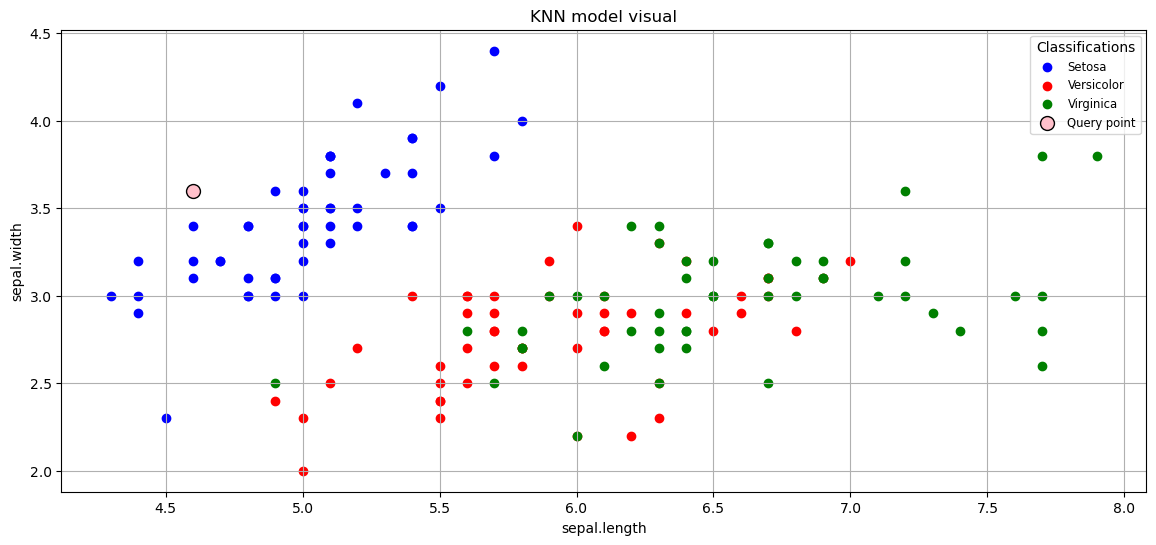

The datapoint randomly pulled from the set had Outcome: 0.0
The closest neighbors identified have indicies [73, 363, 546, 317, 441, 699, 143]
The model has classified the point as Outcome: 0.0


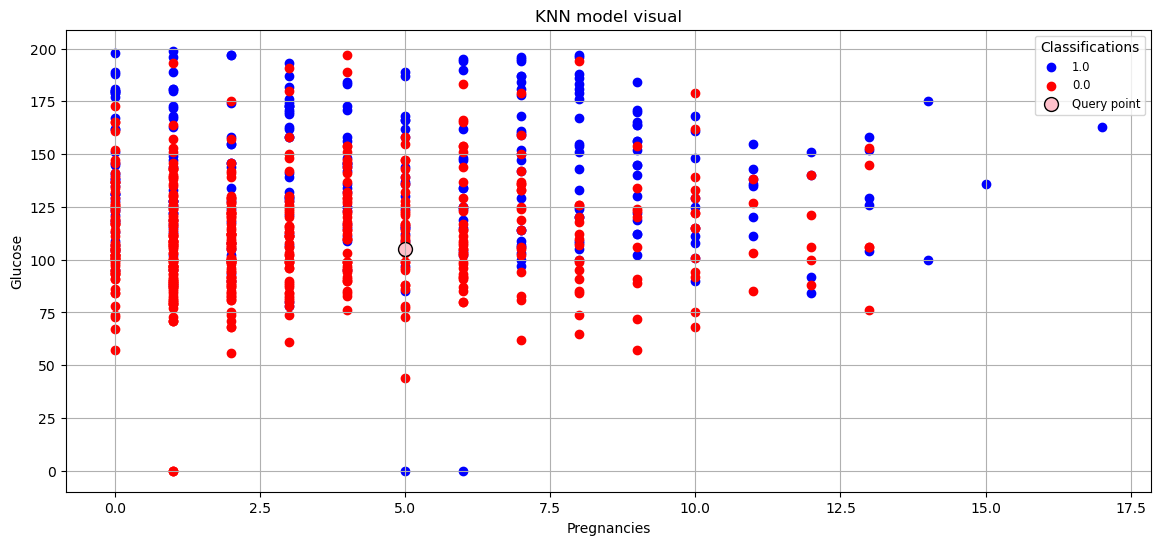

In [23]:
p,n = iris_dataset.yoink_data_point() #p is normalized, n is not
iris_model.categorize(p, True)
iris_dataset.post_yoink_restore()



iris_model.display(point_to_add = n)

p,n = diabetes_dataset.yoink_data_point()
diabetes_model.categorize(p, True)
diabetes_dataset.post_yoink_restore()

diabetes_model.display(point_to_add=n)






